<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/multi_gpu_training_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a CNN on multiple GPUs using data parallelism.
Based on sec 12.5 of http://d2l.ai/chapter_computational-performance/multiple-gpus.html.

Note: in colab, we only have access to 1 GPU, so the code below just simulates the effects of multiple GPUs, so it will not run faster. You may not see a speedup eveen on a machine which really does have multiple GPUs, because the model and data are too small. But the example should still illustrate the key ideas.



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

# Model

We use a slightly modified version of the LeNet CNN.

In [7]:
# Initialize model parameters
scale = 0.01
torch.random.manual_seed(0)
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')

# Copying parameters across devices

In [5]:
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [10]:
# Copy the params to GPU0
gpu0 = torch.device('cuda:0')
new_params = get_params(params, gpu0)
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


In [12]:
# Copy the params to GPU1
gpu1 = torch.device('cuda:0') # torch.device('cuda:1')
new_params = get_params(params, gpu1)
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


All-reduce will copy data (eg gradients) from all devices to device 0, add them, and then broadcast the result back to each device.

In [13]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

In [14]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


# Distribute data across GPUs

In [16]:
data = torch.arange(20).reshape(4, 5)
#devices = [torch.device('cuda:0'), torch.device('cuda:1')]
devices = [torch.device('cuda:0'), torch.device('cuda:0')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=0)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'))


Split data and labels.

In [18]:

def split_batch(X, y, devices):
    """Split `X` and `y` into multiple devices."""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices), nn.parallel.scatter(y, devices))

# Training

In [20]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [21]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # Loss is calculated separately on each GPU
    losses = [
        loss(lenet(X_shard, device_W),
             y_shard).sum() for X_shard, y_shard, device_W in zip(
                 X_shards, y_shards, device_params)]
    for l in losses:  # Back Propagation is performed separately on each GPU
        l.backward()
    # Sum all gradients from each GPU and broadcast them to all GPUs
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # The model parameters are updated separately on each GPU
    ndata = X.shape[0] # gradient is summed over the full minibatch
    for param in device_params:
        #d2l.sgd(param, lr, ndata)
        sgd(param, lr, ndata)   

In [22]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # Copy model parameters to num_gpus GPUs
    device_params = [get_params(params, d) for d in devices]
    # num_epochs, times, acces = 10, [], []
    num_epochs = 5
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # Perform multi-GPU training for a single minibatch
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # Verify the model on GPU 0
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

test acc: 0.80, 4.4 sec/epoch on [device(type='cuda', index=0)]


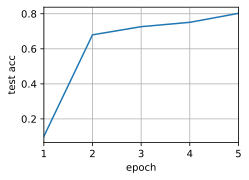

In [24]:
#train(num_gpus=2, batch_size=256, lr=0.2)
train(num_gpus=1, batch_size=256, lr=0.2)